In [87]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

from prediction.data.code_mappings import status_codes
from prediction.data.dataset import AISCompletionDataset
from prediction.data.filter_data import filter_by_travelled_distance
from prediction.model.trfmls import TRFMLS
from prediction.preprocessing.ais_status_segmentation import segment_by_status

from prediction.visualization import plot_north_america, plot_trajectories
from prediction.data.filter_data import filter_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Run the `trajectory_resampling.ipynb` notebotok to generate the data required for this notebook.

In [88]:
df = pd.read_pickle("trajectories_resampled.pkl")

In [89]:
all_codes = status_codes().keys()
all_codes = [code for code in all_codes if code != 0]

df = segment_by_status(df, "statuses", 5, all_codes, 100)
len(df)

2861

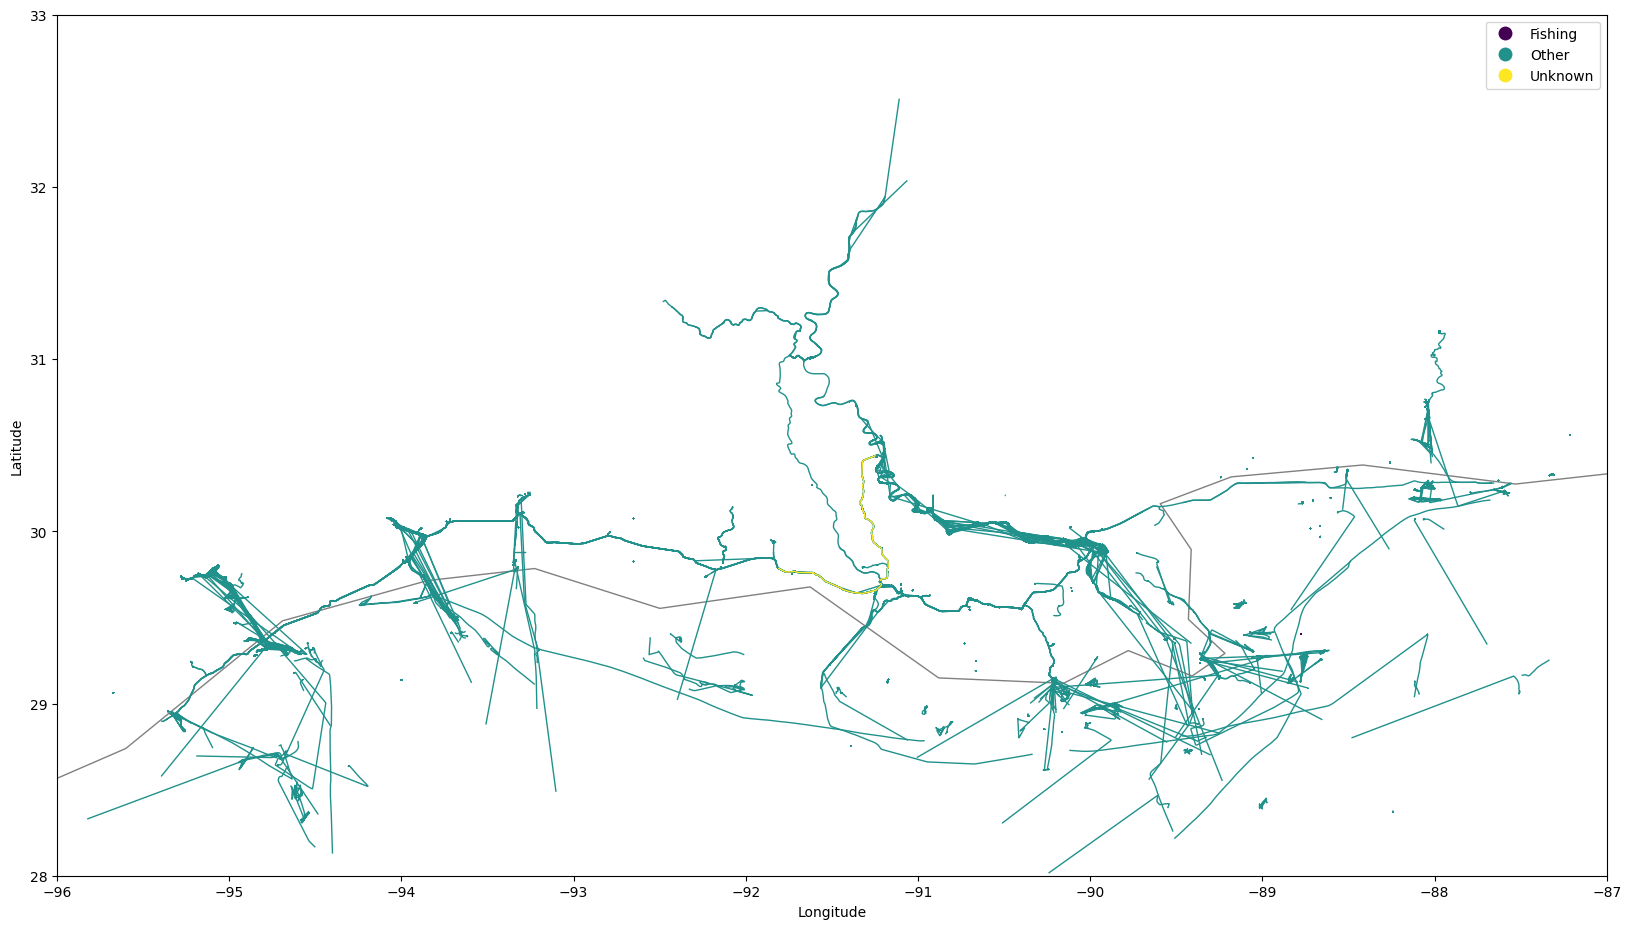

In [90]:
min_lat, min_lon = 28, -96
max_lat, max_lon = 33, -87

polygon = Polygon([(min_lon, min_lat), (min_lon, max_lat), (max_lon, max_lat), (max_lon, min_lat)])
df = filter_data(df, polygon)

fig, ax = plt.subplots(figsize=(20, 15))
plot_north_america(ax)
plot_trajectories(df, ax)

# cut axes to north america
ax.set_xlim(-96, -87)
ax.set_ylim(28, 33)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [91]:
df = filter_by_travelled_distance(df, 5, None)
len(df)

573

In [92]:
dataset = AISCompletionDataset(df, n_pred=20, seq_len=40, include_timestamps=False, include_speed=False, include_orientation=False, normalize=True)

Skipped 7 rows due to insufficient data


100%|██████████| 52/52 [00:00<00:00, 13948.82it/s]


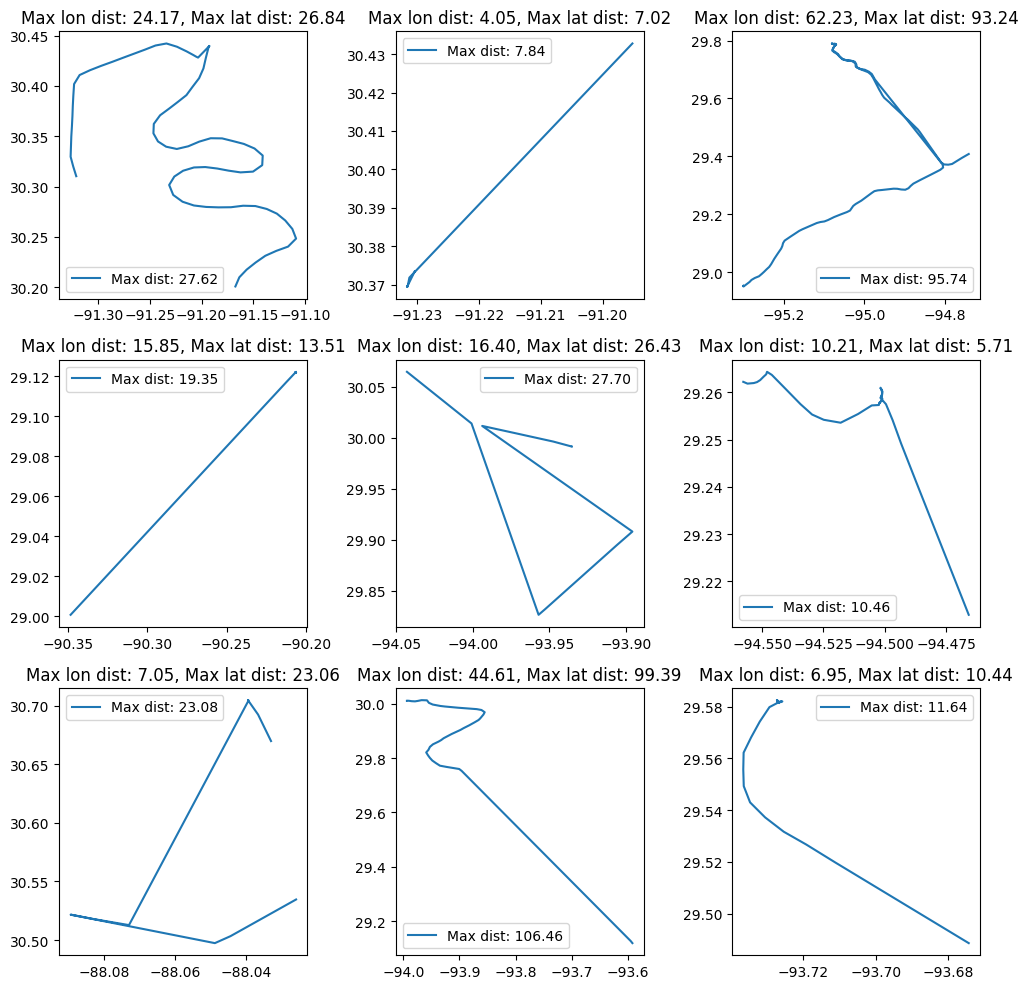

In [93]:
import random

import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import LineString

from prediction.preprocessing.utils import haversine, pairwise_point_distances


def find_max_lon_dist(line: LineString):
    """Find the maximum longitude distance in the line"""
    max_lon = max([lon for lon, _ in line.coords])
    min_lon = min([lon for lon, _ in line.coords])
    return haversine(0, max_lon, 0, min_lon)


def find_max_lat_dist(line: LineString):
    """Find the maximum latitude distance in the line"""
    max_lat = max([lat for _, lat in line.coords])
    min_lat = min([lat for _, lat in line.coords])
    return haversine(max_lat, 0, min_lat, 0)


def plot_random_trajectory(data: pd.DataFrame, idx: int, ax: plt.Axes):
    """Plot a random trajectory with the furthest point distance"""
    row = data.iloc[idx]
    line = row["geometry"]
    max_distance = pairwise_point_distances(line).max()
    lon_dist = find_max_lon_dist(line)
    lat_dist = find_max_lat_dist(line)
    ax.plot(*line.coords.xy, label=f"Max dist: {max_distance:.2f}")
    ax.set_title(f"Max lon dist: {lon_dist:.2f}, Max lat dist: {lat_dist:.2f}")
    ax.legend()


fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    plot_random_trajectory(df, random.randint(0, len(df)), ax[i // 3, i % 3])

plt.tight_layout()
plt.show()

In [94]:
len(dataset)

566

In [95]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [96]:
def train_model(
    model: TRFMLS,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int,
    learning_rate: float,
    device: torch.device,
    scheduler: bool = True,
    early_stopping: bool = True,
    patience: int = 10,
):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    if scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", patience=5, factor=0.5, verbose=True
        )

    model = model.to(device)

    best_val_loss = float("inf")
    patience_counter = 0

    # Main epoch loop without progress bar
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0

        # Training loop with progress bar
        train_pbar = tqdm(train_loader, desc=f"Training {epoch+1}/{num_epochs}", leave=True)
        for src, decoder_in, tgt in train_pbar:
            # print(src.shape, decoder_in.shape, tgt.shape)
            src = src.float().to(device)
            decoder_in = decoder_in.float().to(device)
            tgt = tgt.float().to(device)

            optimizer.zero_grad()

            output = model(src, decoder_in)
            loss = criterion(output, tgt)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            train_pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        # Validation loop with progress bar
        model.eval()
        val_loss = 0

        val_pbar = tqdm(val_loader, desc=f"Validation {epoch+1}/{num_epochs}", leave=True)
        with torch.no_grad():
            for src, decoder_in, tgt in val_pbar:
                src = src.float().to(device)
                decoder_in = decoder_in.float().to(device)
                tgt = tgt.float().to(device)

                output = model(src, decoder_in)
                loss = criterion(output, tgt)
                val_loss += loss.item()
                val_pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        # Calculate and print average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}\n")

        if scheduler:
            scheduler.step(avg_val_loss)

        if early_stopping:
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save(model.state_dict(), "best_model.pth")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch + 1} epochs")
                    break

        if (epoch + 1) % 10 == 0:
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "train_loss": avg_train_loss,
                    "val_loss": avg_val_loss,
                },
                f"checkpoint_epoch_{epoch+1}.pth",
            )


def evaluate_model(model: TRFMLS, test_loader: DataLoader, device: torch.device):
    model.eval()
    total_loss = 0
    criterion = nn.MSELoss()

    predictions = []
    targets = []

    # Evaluation loop with progress bar
    eval_pbar = tqdm(test_loader, desc="Evaluating")
    with torch.no_grad():
        for src, decoder_in, tgt in eval_pbar:
            src = src.float().to(device)
            decoder_in = decoder_in.float().to(device)
            tgt = tgt.float().to(device)

            output = model(src, decoder_in)
            loss = criterion(output, tgt)
            total_loss += loss.item()

            predictions.append(output.cpu().numpy())
            targets.append(tgt.cpu().numpy())

            eval_pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(test_loader)
    print(f"\nTest Loss: {avg_loss:.4f}")

    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)

    return predictions, targets, avg_loss

In [97]:
model = TRFMLS(
    input_dim=2,
    d_model=128,
    nhead=8,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=512,
    max_seq_len=40,
    output_dim=2,
    dropout=0.1,
    batch_first=True,
)

In [98]:
training_args = {
    "num_epochs": 10,
    "learning_rate": 0.001,
    "device": torch.device("mps"),
    "scheduler": True,
    "early_stopping": True,
    "patience": 10,
}

# Train the model
train_model(model, train_loader, val_loader, **training_args)

# Evaluate on test set
predictions, targets, test_loss = evaluate_model(model, val_loader, training_args["device"])

/Users/marcus/Documents/Workspace/python-envs/ais-env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Validation 1/10: 100%|██████████| 4/4 [00:00<00:00, 47.33it/s, loss=0.0041]


Epoch 1/10
Training Loss: 3.8418
Validation Loss: 0.0043



Validation 2/10: 100%|██████████| 4/4 [00:00<00:00, 61.70it/s, loss=0.0051]


Epoch 2/10
Training Loss: 0.0959
Validation Loss: 0.0049



Validation 3/10: 100%|██████████| 4/4 [00:00<00:00, 52.44it/s, loss=0.0140]


Epoch 3/10
Training Loss: 0.0540
Validation Loss: 0.0143



Validation 4/10: 100%|██████████| 4/4 [00:00<00:00, 58.74it/s, loss=0.0039]


Epoch 4/10
Training Loss: 0.0334
Validation Loss: 0.0039



Validation 5/10: 100%|██████████| 4/4 [00:00<00:00, 54.46it/s, loss=0.0098]


Epoch 5/10
Training Loss: 0.0221
Validation Loss: 0.0101



Validation 6/10: 100%|██████████| 4/4 [00:00<00:00, 61.66it/s, loss=0.0057]


Epoch 6/10
Training Loss: 0.0158
Validation Loss: 0.0058



Validation 7/10: 100%|██████████| 4/4 [00:00<00:00, 61.06it/s, loss=0.0011]


Epoch 7/10
Training Loss: 0.0116
Validation Loss: 0.0012



Validation 8/10: 100%|██████████| 4/4 [00:00<00:00, 62.92it/s, loss=0.0020]


Epoch 8/10
Training Loss: 0.0081
Validation Loss: 0.0021



Validation 9/10: 100%|██████████| 4/4 [00:00<00:00, 56.72it/s, loss=0.0018]


Epoch 9/10
Training Loss: 0.0067
Validation Loss: 0.0019



Validation 10/10: 100%|██████████| 4/4 [00:00<00:00, 59.20it/s, loss=0.0007]


Epoch 10/10
Training Loss: 0.0061
Validation Loss: 0.0007



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 68.24it/s, loss=0.0007]


Test Loss: 0.0007


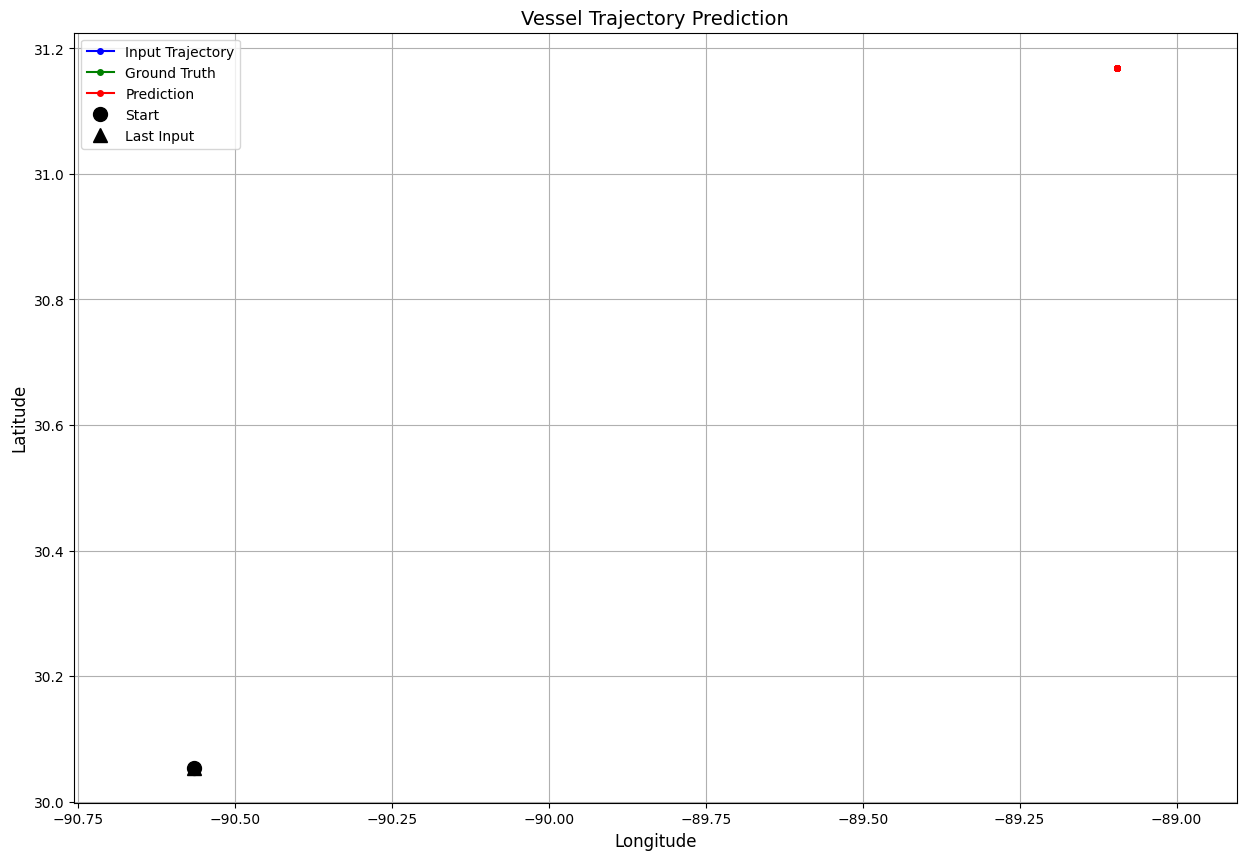

Input sequence length: 40
Prediction length: 20

MSE between prediction and ground truth: 1.7043


In [99]:
import random

import matplotlib.pyplot as plt


def plot_trajectory_prediction(
    model: TRFMLS, val_dataset, device: torch.device, idx: int = None, save_path: str = None
):
    model.eval()

    if idx is None:
        idx = random.randint(0, len(val_dataset) - 1)

    # Get sample from dataset
    src, decoder_in, tgt = val_dataset[idx]

    # Convert to torch tensors and ensure float32
    src = torch.from_numpy(src).to(torch.float32).unsqueeze(0)
    decoder_in = torch.from_numpy(decoder_in).to(torch.float32).unsqueeze(0)
    tgt = torch.from_numpy(tgt).to(torch.float32)

    # Generate prediction
    with torch.no_grad():
        zeros = torch.zeros_like(decoder_in, dtype=torch.float32).to(device)
        pred = model(src.to(device), tgt.to(device).unsqueeze(0))  # tgt.to(device).unsqueeze(0)
        pred = pred.cpu().numpy().squeeze()

    # Convert back to numpy and denormalize
    src = src.squeeze().cpu().numpy()
    tgt = tgt.cpu().numpy()  # Convert tgt to numpy

    # Denormalize
    src[:, :2] = src[:, :2] * np.array([90, 180])
    tgt[:, :2] = tgt[:, :2] * np.array([90, 180])
    pred[:, :2] = pred[:, :2] * np.array([90, 180])

    # Create figure
    plt.figure(figsize=(15, 10))

    # Plot source trajectory
    plt.plot(src[:, 0], src[:, 1], "b.-", label="Input Trajectory", markersize=8)

    # Plot ground truth future trajectory
    plt.plot(tgt[:, 0], tgt[:, 1], "g.-", label="Ground Truth", markersize=8)

    # Plot predicted trajectory
    plt.plot(pred[:, 0], pred[:, 1], "r.-", label="Prediction", markersize=8)

    # Add markers for start and end points
    plt.plot(src[0, 0], src[0, 1], "ko", label="Start", markersize=10)
    plt.plot(src[-1, 0], src[-1, 1], "k^", label="Last Input", markersize=10)

    # Add title and labels
    plt.title("Vessel Trajectory Prediction", fontsize=14)
    plt.xlabel("Longitude", fontsize=12)
    plt.ylabel("Latitude", fontsize=12)
    plt.grid(True)
    plt.legend(fontsize=10)

    # Make equal aspect ratio
    plt.axis("equal")

    if save_path:
        plt.savefig(save_path)

    plt.show()

    # Print statistics
    print(f"Input sequence length: {len(src)}")
    print(f"Prediction length: {len(pred)}")

    if src.shape[1] > 2:
        print("\nSpeed statistics:")
        print(f"Average input speed: {src[:, 2].mean():.2f}")
        print(f"Average predicted speed: {pred[:, 2].mean():.2f}")
        print(f"Average ground truth speed: {tgt[:, 2].mean():.2f}")

    # Now both pred and tgt are numpy arrays
    mse = ((pred - tgt) ** 2).mean()
    print(f"\nMSE between prediction and ground truth: {mse:.4f}")


device = "mps"

# Usage:
plot_trajectory_prediction(
    model, train_dataset, device, save_path="trajectory_prediction.png", idx=1  # 10, 38, 39
)